<a href="https://colab.research.google.com/github/EldarAlimov/Pet-Projects/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_zip_path = '/content/drive/My Drive/SegmentationDatasets/train.zip'
test_zip_path = '/content/drive/My Drive/SegmentationDatasets/test.zip'
train_extract_path = '/content/Segmentation/train'
test_extract_path = '/content/Segmentation/test'


for zip_path, extract_path in [(train_zip_path, train_extract_path), (test_zip_path, test_extract_path)]:
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Архив {zip_path} успешно распакован.")
    else:
        print(f"Файл {zip_path} не найден. Убедитесь, что путь указан правильно.")

Архив /content/drive/My Drive/SegmentationDatasets/train.zip успешно распакован.
Архив /content/drive/My Drive/SegmentationDatasets/test.zip успешно распакован.


In [ ]:
def load_images_and_masks(image_dir, mask_dir=None, img_size=(128, 128)):
    images = []
    masks = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)

        if mask_dir:
            # Replace image extension with .png for the corresponding mask
            mask_name = os.path.splitext(img_name)[0] + ".png"
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0
                masks.append(mask)
            else:
                print(f"Warning: Mask file not found for {img_name}")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {image_dir}")

    if mask_dir:
        return np.array(images), np.array(masks)
    return np.array(images)



In [ ]:
# Загружаем данные
train_image_dir = os.path.join(train_extract_path, "train/images")
train_mask_dir = os.path.join(train_extract_path, "train/masks")
test_image_dir = os.path.join(test_extract_path, "test/images")

img_size = (128, 128)

X_train, Y_train = load_images_and_masks(train_image_dir, train_mask_dir, img_size)
X_test = load_images_and_masks(test_image_dir, img_size=img_size)

Loaded 7000 images and 7000 masks from /content/Segmentation/train/train/images
Loaded 4000 images and 0 masks from /content/Segmentation/test/test/images


In [ ]:
checkDir1 = train_image_dir
if os.path.exists(checkDir1):
    print("Содержимое директории "+checkDir1)
    print(os.listdir(checkDir1))
else:
    print("/content/train не существует.")

print()

checkDir2 = train_mask_dir
if os.path.exists(checkDir2):
    print("Содержимое директории "+checkDir2)
    print(os.listdir(checkDir2))
else:
    print("/content/train не существует.")

Пример изображений и масок из тренировочного набора:


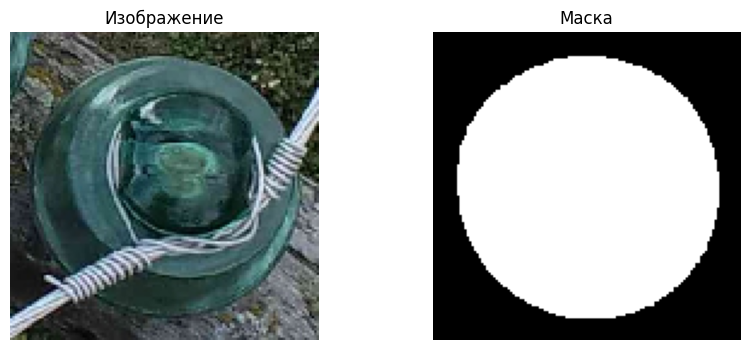

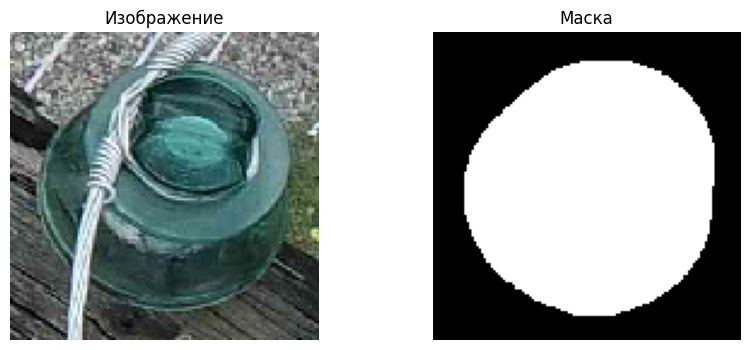

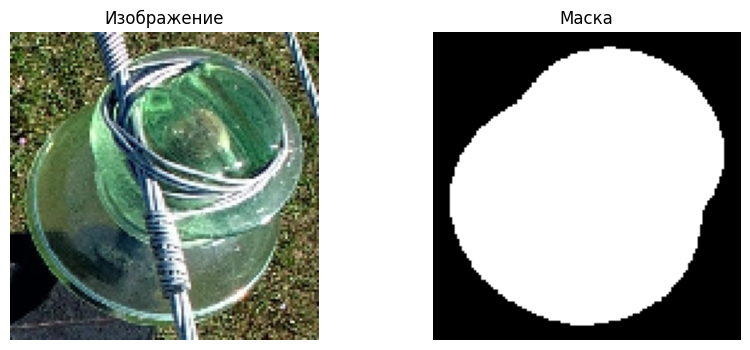

In [ ]:
# Проверочный вывод 3 изображений и соответствующих масок
import matplotlib.pyplot as plt
print("Пример изображений и масок из тренировочного набора:")
for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title("Изображение")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[i].squeeze(), cmap="gray")
    plt.title("Маска")
    plt.axis("off")
    plt.show()

In [ ]:
print("Пример значений масок:", np.unique(Y_train[0]) if len(Y_train) > 0 else "Маски не загружены")

Пример значений масок: Маски не загружены


In [ ]:
# Разделяем тренировочные данные на обучающие и валидационные
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Определяем простую модель U-Net
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Downsampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling
    u1 = UpSampling2D((2, 2))(c3)
    u1 = Concatenate()([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = Concatenate()([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32
)

In [ ]:

output_dir = '/content/test_predictions'
os.makedirs(output_dir, exist_ok=True)

for idx, img in enumerate(X_test):
    prediction = model.predict(np.expand_dims(img, axis=0))[0]
    prediction = (prediction > 0.5).astype(np.uint8)  # Бинаризация
    mask = array_to_img(prediction)

    # Имя файла соответствует имени оригинального изображения
    img_name = os.listdir(test_image_dir)[idx].replace('.jpg', '.png')
    mask.save(os.path.join(output_dir, img_name))

# Архивация результатов
shutil.make_archive("/content/test_predictions", 'zip', output_dir)
print("Результаты сохранены и упакованы в архив test_predictions.zip")

In [ ]:
import shutil
shutil.make_archive("/content/test_predictions", 'zip', output_dir)
print("Результаты сохранены и упакованы в архив test_predictions.zip")

Результаты сохранены и упакованы в архив test_predictions.zip


In [ ]:
from google.colab import files
files.download('/content/test_predictions.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import glob

# Путь к директории
directory = '/content/test_predictions'

# Получаем все PNG файлы в директории
png_files = glob.glob(os.path.join(directory, '*.png'))

# Удаляем только PNG файлы
for f in png_files:
    os.remove(f)

In [ ]:
print(os.listdir('/content/test_predictions'))

[]
